# Movie Recommendations

Recommendation systems are used to filter among a catalog of possibilities, which ones should be presented to the user. Those systems can be used to enhance the user experience by making the content available to user relavant. In this project, we're going to explore a <a href="https://grouplens.org/datasets/movielens/25m/">movie dataset</a>, and present some of the key types of recommendations systems.

## 1. Importing and inspecting data

### 1.1 Inspection

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

We start by importing and checking our data.

In [2]:
movies = pd.read_parquet("../data/movies.parquet")
ratings = pd.read_parquet("../data/ratings.parquet")

In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [5]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [6]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 762.9 MB


In [7]:
movies.describe()

,movieId
count,62423.000000
mean,122220.387646
std,63264.744844
min,1.000000
25%,82146.500000
50%,138022.000000
75%,173222.000000
max,209171.000000


In [8]:
ratings.describe()

,userId,movieId,rating,timestamp
count,2.500010e+07,2.500010e+07,2.500010e+07,2.500010e+07
mean,8.118928e+04,2.138798e+04,3.533854e+00,1.215601e+09
std,4.679172e+04,3.919886e+04,1.060744e+00,2.268758e+08
min,1.000000e+00,1.000000e+00,5.000000e-01,7.896520e+08
25%,4.051000e+04,1.196000e+03,3.000000e+00,1.011747e+09
50%,8.091400e+04,2.947000e+03,3.500000e+00,1.198868e+09
75%,1.215570e+05,8.623000e+03,4.000000e+00,1.447205e+09
max,1.625410e+05,2.091710e+05,5.000000e+00,1.574328e+09


In [9]:
ratings['rating'].value_counts()

4.0    6639798
3.0    4896928
5.0    3612474
3.5    3177318
4.5    2200539
2.0    1640868
2.5    1262797
1.0     776815
1.5     399490
0.5     393068
Name: rating, dtype: int64

`dtype` for ratings seems to be a bit too much.

Checking for missing data.

In [10]:
movies.isna().sum()

movieId    0
title      0
genres     0
dtype: int64

In [11]:
ratings.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Checking duplicates.

In [12]:
movies.duplicated().sum()

0

In [13]:
ratings.duplicated().sum()

0

In [14]:
# There are duplicated titles
movies['title'].duplicated().sum()

98

We don't have any nulls or duplicated data. But be mindful that there are duplicated movies titles.

### 1.2 Preprocessing

In [15]:
# We can set the movieId as index for the table

movies = movies.set_index('movieId')

In [16]:
# We won't be using the timestamp

ratings = ratings.drop('timestamp', axis=1)

In [17]:
ratings['rating'] = ratings['rating'].astype(np.float16)

In [18]:
movies.head()

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


In [19]:
ratings.head()

,userId,movieId,rating
0,1,296,5.0
1,1,306,3.5
2,1,307,5.0
3,1,665,5.0
4,1,899,3.5


In [20]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int64  
 1   movieId  int64  
 2   rating   float16
dtypes: float16(1), int64(2)
memory usage: 429.2 MB


Reduced memory usage significantly without any loss.

## 2. Feature extraction

We are going to extract the year from the title of the movie and create genres columns.

In [104]:
# Extracting year from title with regex
movies_year = movies['title'].str.extract(r'\((\d{4})\)')
movies_year.columns = ['year']
movies_year

,year
movieId,
1,1995
2,1995
3,1995
4,1995
5,1995
...,...
209157,2018
209159,2001
209163,2018


In [103]:
# Creating genres columns
movies_genres = movies['genres'].str.get_dummies('|')
movies_genres

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,,
1,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209157,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
209159,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
209163,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0


We could convert the timestamp to datetime to get temporal features. But for now, we stick to those features.

## 3. EDA

In [49]:
# Auxiliary functions

def get_id_from_title(title):
    return movies.loc[movies['title'] == title].index.item()

def get_title_from_id(movieId):
    return movies.loc[movieId].title

Let's explore the dataset to get some insights.

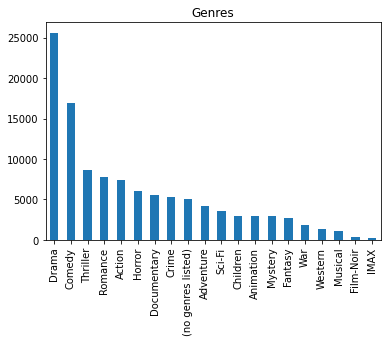

In [50]:
# Most present genres
movies_genres.sum().sort_values(ascending=False).plot(kind='bar')
plt.title('Genres')
plt.show()

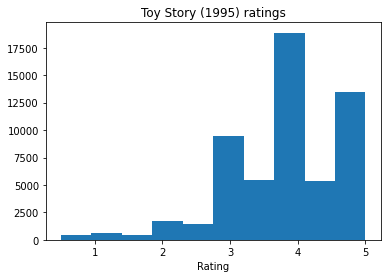

In [55]:
# Choose a movie, and check the rating distribution
plt.hist(ratings.loc[ratings['movieId'] == get_id_from_title('Toy Story (1995)'), 'rating'])
plt.xlabel('Rating')
plt.title('Toy Story (1995) ratings')
plt.show()

In [93]:
# Ratings count - What are the top 3% most rated movies?

ratings_count_percentage = ratings['movieId'].value_counts(normalize=True)

top_3_percent = ratings_count_percentage[ratings_count_percentage.cumsum() < 0.03]
top_3_percent.rename('rating_percentage', inplace=True)
top_3_percent = pd.merge(left=top_3_percent, right=movies['title'], left_index=True, right_on='movieId')

top_3_percent['rating_percentage_cum'] = top_3_percent['rating_percentage'].cumsum()

top_3_percent

,rating_percentage,title,rating_percentage_cum
movieId,,,
356,0.003260,Forrest Gump (1994),0.003260
318,0.003259,"Shawshank Redemption, The (1994)",0.006519
296,0.003187,Pulp Fiction (1994),0.009706
593,0.002965,"Silence of the Lambs, The (1991)",0.012671
2571,0.002907,"Matrix, The (1999)",0.015578
260,0.002749,Star Wars: Episode IV - A New Hope (1977),0.018326
480,0.002566,Jurassic Park (1993),0.020892
527,0.002416,Schindler's List (1993),0.023309
110,0.002367,Braveheart (1995),0.025676


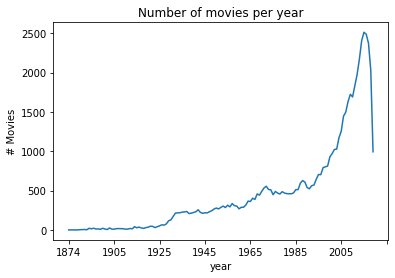

In [109]:
# Movies per year

movies_year.groupby('year').size().plot()
plt.ylabel('# Movies')
plt.title('Number of movies per year')
plt.show()

In [18]:
# We could explore more questions:
# Movie time series per gender
# What's the highest mean rating movie?

## 4. Search engine

Our first task is to make a **search engine**. When a user type a movie title, a function search the most similar rows in the database. First we clean our titles to get only letters and numbers and convert every instance in a vector using **TF-IDF**. Then, we compare those vectors using **cosine similarity** and return the best items.

In [19]:
# Cleaning titles with regex

import re

def clean(title):
    return re.sub("[^a-zA-Z0-9 ]", "", title)

movies["clean_titles"] = movies["title"].apply(clean)

In [20]:
# TF-IDF

from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer(ngram_range=(1, 3))

titles_vec = vec.fit_transform(movies["clean_titles"])

In [21]:
from sklearn.metrics.pairwise import cosine_similarity

def search(title):
    title = clean(title)
    query_vec = vec.transform([title])
    similarity = cosine_similarity(query_vec, titles_vec).flatten()
    
    # Selecting top 5 movies
    idx = np.argpartition(similarity, kth=-5)[-5:]

    results = movies.iloc[idx][::-1]
    return results

In [22]:
import ipywidgets as widgets
from IPython.display import display

movie_input = widgets.Text(description="Movie title", value="Toy Story 1995", disabled=False)
movie_output = widgets.Output()

def when_type(data):
    with movie_output:
        movie_output.clear_output()
        title = data["new"]
        if len(title) > 5:
            display(search(title))

movie_input.observe(when_type, names='value')

In [23]:
display(movie_input, movie_output)

Text(value='Toy Story 1995', description='Movie title')

Output()

## 5. Recomendation systems

### 5.1 Non-personalized recomendations

Our first recommenders are **non-personalized** in the sense that they are not based on the individual user information. The information used can be the global watch rate, ratings, seem together movies or content based recommendations. Those systems are useful as product showcase.

#### 5.1.1 High rate/watch movies

A first recommender can be made by ranking the best reviewed movies, but filtering by only movies with a certain number of reviews.

In [24]:
# Movies with more than 500 reviews

review_count = ratings["movieId"].value_counts()
review_count_percentage = review_count / len(ratings["userId"].unique())
pop_movies_100 = review_count_percentage.iloc[:100].index

In [25]:
# Best reviewed movies

pop_movies_ratings = ratings[ratings["movieId"].isin(pop_movies_100)]
movie_rec = pop_movies_ratings[["rating", "movieId"]].groupby("movieId").mean().sort_values(by="rating", 
                                                                           ascending=False).reset_index()


In [26]:
movie_rec.merge(right=movies[["movieId", "title"]], on="movieId").head(10)

,movieId,rating,title
0,318,4.413576,"Shawshank Redemption, The (1994)"
1,858,4.324336,"Godfather, The (1972)"
2,50,4.284353,"Usual Suspects, The (1995)"
3,1221,4.261759,"Godfather: Part II, The (1974)"
4,527,4.247579,Schindler's List (1993)
5,2959,4.228311,Fight Club (1999)
6,1193,4.218662,One Flew Over the Cuckoo's Nest (1975)
7,296,4.188912,Pulp Fiction (1994)
8,1213,4.180525,Goodfellas (1990)
9,58559,4.166538,"Dark Knight, The (2008)"


It surelly works, but is *pretty generic*.

#### 5.1.2 Most seem together

If a some users usually watch some movies together, those are probably a good recomendation for another user.
The problem of this approach is the memory usage required to compute and store the permutations between the movies. The code used to generate a database with the permutations is commented due to time requirements, but once precomputed, our task is a simple query.

In [27]:
# from itertools import permutations

# def create_pairs(x):
#     pairs = pd.DataFrame(list(permutations(x.values, 2)), columns=["movie_a", "movie_b"])
#     return pairs

# # Getting a smaller sample from ratings
# n_users = 1000
# selected_users = ratings['userId'].sample(n_users, replace=False).values
# small_ratings = ratings.loc[ratings["userId"].isin(selected_users), ["userId", "movieId"]]

# # Get a smaller movie subset
# small_ratings_count = small_ratings["movieId"].value_counts()
# small_ratings_count = small_ratings_count[small_ratings_count > 250]
# smaller_ratings = small_ratings[small_ratings["movieId"].isin(small_ratings_count.index)]

# # Counting the pairs movies watched by the same user
# pair_counts = smaller_ratings.groupby("userId")["movieId"].apply(create_pairs).reset_index(drop=True)

# # Saving the results
# pair_counts.to_parquet("../data/pair_counts.parquet")

In [28]:
# Importing the permutations previously generated

pair_counts = pd.read_parquet("../data/pair_counts.parquet")
pair_counts = pair_counts.groupby(["movie_a", "movie_b"]).size().to_frame(name='size').reset_index()

# Getting movie_a titles

pair_counts_a = pair_counts.merge(right=movies[["movieId", "title"]], left_on="movie_a", right_on="movieId")[["title", "movie_b", "size"]]
pair_counts_a = pair_counts_a.rename(columns={"title":"movie_a"})

# Getting movie_b titles
pair_counts_b = pair_counts_a.merge(right=movies[["movieId", "title"]], left_on="movie_b", right_on="movieId")[["movie_a", "title", "size"]]
pair_counts = pair_counts_b.rename(columns={"title":"movie"})

In [29]:
def seem_together_recommendation(movie):
    pairs = pair_counts[pair_counts["movie_a"] == movie]
    pairs_sorted = pairs.sort_values(by="size", ascending=False)[["movie"]]
    return pairs_sorted.head(10)

In [30]:
seem_together_recommendation("Toy Story (1995)")

,movie
10624,Forrest Gump (1994)
8632,Pulp Fiction (1994)
61420,"Matrix, The (1999)"
7304,Star Wars: Episode IV - A New Hope (1977)
13944,Jurassic Park (1993)
18260,"Silence of the Lambs, The (1991)"
9296,"Shawshank Redemption, The (1994)"
37848,Back to the Future (1985)
30212,Raiders of the Lost Ark (Indiana Jones and the...
32536,Star Wars: Episode VI - Return of the Jedi (1983)


Now we are going somewhere. Our recomendations to Toy Story are very non-trivial.

#### 5.1.3 Content-based recommendation

Since we have some information on our product, we can use our descriptors (in this case, the genres) to recommend similar products.

In [31]:
from sklearn.metrics import jaccard_score

def jaccard_similarities_recomendation(movieId):
    """
    Get the jaccard similarities between a movie and all others and sort them.
    Then, get the top 10 recommendations.
    """
    pop_movies_1000 = review_count_percentage.iloc[:1000].index
    pop_movies = movies[movies['movieId'].isin(pop_movies_1000)]
    movies_and_genres = pop_movies[['movieId']].join(genres).set_index('movieId')
    movie_row = movies_and_genres.loc[movieId]
    movies_and_genres['similarities'] = movies_and_genres.apply(lambda x: jaccard_score(movie_row, x), axis=1)
    movies_and_genres = movies_and_genres.sort_values(by='similarities', ascending=False)
    
    return movies_and_genres.head(10).join(movies.set_index('movieId'))[['title', 'genres']]

In [32]:
# Testing for the movieId = 1 (Toy Story 1995)
jaccard_similarities_recomendation(1)

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4016,"Emperor's New Groove, The (2000)",Adventure|Animation|Children|Comedy|Fantasy
2294,Antz (1998),Adventure|Animation|Children|Comedy|Fantasy
3114,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy
4886,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy
673,Space Jam (1996),Adventure|Animation|Children|Comedy|Fantasy|Sc...
4306,Shrek (2001),Adventure|Animation|Children|Comedy|Fantasy|Ro...
108932,The Lego Movie (2014),Action|Adventure|Animation|Children|Comedy|Fan...
78499,Toy Story 3 (2010),Adventure|Animation|Children|Comedy|Fantasy|IMAX


It works well when the user is searching for something similar to the watched movie.

### 5.2 Colaborative filtering

Now we are going to use user ratings to create recommendations. Our strategy is to find similar users that liked the movie we just watch. Next we find the movies they liked. With this, we can create a score that takes into account the popularity of the movie - we don't want movies to be recommended just because they are popular.

First we begin by making a prototype and then pack it all in a function and interface.

In [33]:
# Suppose we our user liked the movie with Id 1 (Toy Story)
movie_id = 1

# Users that watched our movie and rated > 4
similar_users = ratings.loc[(ratings["movieId"] == movie_id) & (ratings["rating"] > 4.0), "userId"].unique()

# High rated movies (>4) that our similiar users watched
similar_users_rec = ratings.loc[(ratings["userId"].isin(similar_users)) & (ratings["rating"] > 4.0), "movieId"]

# Counting how many users watched our recomendation. Getting the percentage from similar users
similar_rec_movies_percentage = (similar_users_rec.value_counts() / len(similar_users))

# Restricting ourselves to 10%
similar_rec_movies_percentage = similar_rec_movies_percentage[similar_rec_movies_percentage > 0.1]

similar_rec_movies_percentage.head(5)

1      1.000000
318    0.445607
260    0.403770
356    0.370215
296    0.367295
Name: movieId, dtype: float64

44.56% of the similar users watched movie with ID 318.

In [34]:
# We don't want movies that are there just because they are already popular

all_users = ratings.loc[(ratings["movieId"].isin(similar_rec_movies_percentage.index)&(ratings["rating"]>4.0))]
all_users_recs_percentage = all_users["movieId"].value_counts() / len(all_users["userId"].unique())
all_users_recs_percentage.head(5)

318     0.342220
296     0.284674
2571    0.244033
356     0.235266
593     0.225909
Name: movieId, dtype: float64

But from *all users*, movie 318 is already liked by 34.22%. Thats probably generic. We should create a score:

$$score = \frac{\text{percentage from similar users}}{\text{percentage from all users}} $$

In [35]:
# Creating a score, sorting by it, and showing the top 10 recs

rec_percentages = pd.concat([similar_rec_movies_percentage, all_users_recs_percentage], axis=1)
rec_percentages.columns = ["similar", "all"]
rec_percentages["score"] = rec_percentages["similar"] / rec_percentages["all"]
rec_percentages = rec_percentages.sort_values("score", ascending=False).iloc[:9].merge(movies, left_index=True, right_on="movieId")

rec_percentages[['title']].head(10)

,title
0,Toy Story (1995)
3021,Toy Story 2 (1999)
2264,"Bug's Life, A (1998)"
14813,Toy Story 3 (2010)
4780,"Monsters, Inc. (2001)"
580,Aladdin (1992)
6258,Finding Nemo (2003)
587,Beauty and the Beast (1991)
8246,"Incredibles, The (2004)"


In [36]:
# Wrapping in a function

def colab_recommendations(movieId):
    similar_users = ratings.loc[(ratings["movieId"] == movieId) & (ratings["rating"] > 4.0), "userId"].unique()
    similar_users_rec = ratings.loc[(ratings["userId"].isin(similar_users)) & (ratings["rating"] > 4.0), "movieId"]
    similar_rec_movies_percentage = (similar_users_rec.value_counts() / len(similar_users))
    similar_rec_movies_percentage = similar_rec_movies_percentage[similar_rec_movies_percentage > 0.1]
    
    all_users = ratings.loc[(ratings["movieId"].isin(similar_rec_movies_percentage.index)&(ratings["rating"]>4.0))]
    all_users_recs_percentage = all_users["movieId"].value_counts() / len(all_users["userId"].unique())
    rec_percentages = pd.concat([similar_rec_movies_percentage, all_users_recs_percentage], axis=1)
    rec_percentages.columns = ["similar", "all"]
    rec_percentages["score"] = rec_percentages["similar"] / rec_percentages["all"]
    rec_percentages = rec_percentages.sort_values("score", ascending=False).iloc[:9].merge(movies, left_index=True, right_on="movieId")
    
    return rec_percentages[['title']].head(10)

In [37]:
movie_input = widgets.Text(description="Movie title", value="The Godfather", disabled=False)
movie_recommendation = widgets.Output()

def when_type(data):
    with movie_recommendation:
        movie_recommendation.clear_output()
        title = data["new"]
        if len(title) > 5:
            results = search(title)
            movie_id = results.iloc[0]["movieId"]
            display(colab_recommendations(movie_id))

movie_input.observe(when_type, names='value')

In [38]:
display(movie_input, movie_recommendation)

Text(value='The Godfather', description='Movie title')

Output()

## KNN

Suppose we want to suggest a new movie for `user 1` and predict its rating.

In [60]:
def get_pop_movies(n):
    """Get the n-first top movies in terms of review counting."""
    return review_count_percentage.iloc[:n].index

In [70]:
movies

,movieId,title,genres,year,clean_titles
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,Toy Story 1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,Jumanji 1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,Grumpier Old Men 1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,Waiting to Exhale 1995
4,5,Father of the Bride Part II (1995),Comedy,1995,Father of the Bride Part II 1995
...,...,...,...,...,...
62418,209157,We (2018),Drama,2018,We 2018
62419,209159,Window of the Soul (2001),Documentary,2001,Window of the Soul 2001
62420,209163,Bad Poems (2018),Comedy|Drama,2018,Bad Poems 2018
62421,209169,A Girl Thing (2001),(no genres listed),2001,A Girl Thing 2001


In [61]:
# Restricting to movies that user 1 watched and pop movies 100
user_movies = ratings.loc[ratings['userId'] == 1, 'movieId'].unique()
pop_movies_200 = get_pop_movies(n=200)

ratings_pop = ratings.loc[(ratings['movieId'].isin(pop_movies_200)) | (ratings['movieId'].isin(user_movies))]

In [64]:
# User based recommendations

ratings_pivot_user = ratings_pop.pivot(index='userId',columns='movieId',values='rating')

In [66]:
# Item based recommendations

ratings_pivot_item = ratings_pivot_user.T

In [41]:
ratings_user_mean = ratings_pivot.mean(axis=1)

In [42]:
ratings_pivot_sub = ratings_pivot.sub(ratings_user_mean, axis=0).fillna(0)

In [43]:
ratings_pivot_sub['user_similarity'] = cosine_similarity(ratings_pivot_sub.iloc[0].values.reshape(1,-1), ratings_pivot_sub)[0]

In [44]:
ratings_small = ratings_pivot_sub.sort_values(by='user_similarity', ascending=False).head(5000)

In [45]:
ratings_small

movieId,1,2,6,10,19,21,32,34,39,47,...,58559,59315,60069,68157,68954,72998,79132,99114,109487,user_similarity
userId,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000
77336,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.359302
137069,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.347178
112033,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.277778,0.000000,0.000000,0.000000,0.0,0.000000,1.277778,0.000000,0.000000,0.289921
43475,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.280941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141792,0.130435,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.084272
26549,0.000000,0.000000,-0.432584,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.567416,...,-0.432584,-0.932584,0.000000,0.567416,0.0,0.000000,-0.432584,-0.432584,-0.932584,0.084271
137320,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.303571,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.084268


# SVD

In [46]:
movie_id = 1

similar_users = ratings.loc[(ratings['movieId'] == 1) & (ratings['rating'] > 4.5), 'userId'].unique()
similar_users_movies = ratings.loc[(ratings['userId'].isin(similar_users)) & (ratings['rating'] > 4.5), 'movieId']
similar_users_movies_percentage = similar_users_movies.value_counts() / len(similar_users)
similar_users_movies_id = similar_users_movies_percentage[similar_users_movies_percentage > 0.05].index.to_numpy()

In [47]:
ratings_small = ratings.loc[(ratings['userId'].isin(similar_users)) & (ratings['movieId'].isin(similar_users_movies_id))]

In [48]:
ratings_pivot = ratings_small.pivot(index='userId',
                                    columns='movieId',
                                    values='rating').drop(1, axis=1)

In [49]:
sparsity = ratings_pivot.count().sum() / ratings_pivot.size

print(f"{(1-sparsity)*100:.2f}% are NaN values.")

73.97% are NaN values.


In [50]:
rating_user_mean = ratings_pivot.mean(axis=1)

In [51]:
ratings_pivot_sub = ratings_pivot.sub(rating_user_mean, axis=0).fillna(0)
ratings_pivot_sub

movieId,6,17,21,25,32,34,36,39,47,50,...,48516,50872,58559,59315,60069,68954,78499,79132,91529,134853
userId,,,,,,,,,,,,,,,,,,,,,
36,0.000000,0.000000,0.000000,0.000000,0.000000,1.026316,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75,-0.654255,0.845745,0.000000,0.000000,0.000000,0.000000,0.000000,-0.654255,-0.154255,0.345745,...,0.000000,-1.154255,-0.654255,-0.654255,0.000000,-0.654255,0.345745,-0.654255,-0.654255,0.000000
86,0.000000,0.000000,-0.357143,0.000000,0.000000,-0.357143,0.000000,0.000000,0.000000,-0.357143,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
90,0.000000,0.363636,0.000000,-0.636364,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
93,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.685185,0.000000,0.000000,0.185185,1.185185,0.185185,0.000000,0.000000,-0.814815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162491,0.000000,0.000000,0.000000,0.217391,0.000000,0.217391,0.000000,0.217391,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
162492,-0.683333,0.000000,0.000000,0.000000,0.316667,0.000000,0.000000,0.000000,0.316667,0.316667,...,0.316667,0.000000,0.316667,0.000000,-0.683333,0.000000,0.000000,0.316667,0.000000,0.000000
162518,-1.076923,0.000000,0.000000,0.000000,-1.076923,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [52]:
from scipy.sparse.linalg import svds

U, sigma, Vt = svds(ratings_pivot_sub)

In [53]:
sigma = np.diag(sigma)

In [54]:
ratings_pred_centered = np.dot(np.dot(U, sigma), Vt)
ratings_pred = ratings_pred_centered + rating_user_mean.values.reshape(-1,1)

In [55]:
pd.DataFrame(ratings_pred, index=ratings_pivot_sub.index,
            columns=ratings_pivot_sub.columns)

movieId,6,17,21,25,32,34,36,39,47,50,...,48516,50872,58559,59315,60069,68954,78499,79132,91529,134853
userId,,,,,,,,,,,,,,,,,,,,,
36,3.867734,3.946114,3.770757,3.759569,3.724277,4.018324,3.919883,3.784648,3.873299,3.995423,...,3.946212,3.951160,3.984815,3.994753,3.970688,3.971703,3.988092,3.926250,3.932800,3.966830
75,3.566429,3.649482,3.572137,3.517426,3.436843,3.829572,3.614246,3.565893,3.432324,3.494033,...,3.617941,3.654780,3.650392,3.640579,3.639862,3.627458,3.602322,3.594186,3.600300,3.640740
86,4.332750,4.354836,4.249193,4.343142,4.427078,4.231735,4.393515,4.168250,4.533273,4.641515,...,4.394673,4.356725,4.424791,4.320314,4.390960,4.384508,4.402663,4.399633,4.358637,4.353567
90,3.559028,3.628233,3.513473,3.505225,3.529837,3.643320,3.600250,3.529422,3.559061,3.675706,...,3.611912,3.637421,3.647142,3.663085,3.657578,3.660427,3.670293,3.596504,3.604060,3.643950
93,3.816981,3.859605,3.915784,3.885900,3.933016,3.870732,3.822875,3.948141,3.704940,3.732928,...,3.791281,3.865662,3.795706,3.833737,3.856022,3.860488,3.837770,3.791500,3.805578,3.843863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162491,3.730204,3.828115,3.710807,3.715643,3.564927,4.030925,3.799954,3.774691,3.641057,3.692814,...,3.761127,3.796148,3.727846,3.773341,3.772533,3.787358,3.783303,3.756324,3.768820,3.791417
162492,4.711499,4.661114,4.723302,4.744070,4.819586,4.581623,4.701064,4.665244,4.803173,4.781832,...,4.710305,4.668465,4.708817,4.655453,4.677675,4.665045,4.664345,4.696003,4.681769,4.666933
162518,4.057182,4.061056,4.051740,4.008506,3.959578,4.126563,4.040340,4.085408,3.984893,3.966915,...,4.054935,4.063131,4.056128,4.099211,4.056195,4.058136,4.058185,4.048320,4.066204,4.072518


In [56]:
ratings_pivot

movieId,6,17,21,25,32,34,36,39,47,50,...,48516,50872,58559,59315,60069,68954,78499,79132,91529,134853
userId,,,,,,,,,,,,,,,,,,,,,
36,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75,3.0,4.5,NaN,NaN,NaN,NaN,NaN,3.0,3.5,4.0,...,NaN,2.5,3.0,3.0,NaN,3.0,4.0,3.0,3.0,NaN
86,NaN,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90,NaN,4.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4.5,NaN,NaN,4.0,5.0,4.0,NaN,NaN,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162491,NaN,NaN,NaN,4.0,NaN,4.0,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
162492,4.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,5.0,5.0,...,5.0,NaN,5.0,NaN,4.0,NaN,NaN,5.0,NaN,NaN
162518,3.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
# User and item based recommendations

# Conclusions and perspectives

We've demonstrated applications of some recommendations systems models. There are other approachs that can be further examinated: item based recommendations with KNN, using SVD to predict ratings and validation tecniques. Nonetheless, the models presented here can with some adjustments be put in production in several situations.